In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import phylovelo as pv
import numpy as np
from scipy.stats import spearmanr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Load 

In [1]:
import pyreadr
globalumap = pyreadr.read_r('./datasets/Celegans/globalumap2d_Qin.rds')
globalumap = globalumap[None]

In [15]:
cell_annotation = pd.read_csv('./datasets/Celegans/GSE126954_cell_annotation.csv', index_col=0)
count = pd.read_csv('./datasets/Celegans/pseudoembryo0_count.csv', index_col=0)
sample = count.index

In [16]:
sd = pv.data_struct.scData(count=count, Xdr=globalumap.loc[sample], cell_generation=cell_annotation.loc[sample].lineage.apply(lambda x: len(x.split('/')[0])).to_numpy().flatten())
sd.drop_duplicate_genes(target='count')
sd.normalize_filter(is_normalize=False, is_log=False, min_count=10, target_sum=None)

In [17]:
sd = pv.inference.velocity_inference(sd, sd.cell_generation, cutoff=0.95, target='count')
sd = pv.embedding.velocity_embedding(sd, target='count', n_neigh=15)

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:29: RuntimeWarning: divide by zero encountered in log
  pmf0 = -n_zeros * np.log((1 - psi) + psi * (n / (n + mu)) ** n)
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:29: RuntimeWarning: invalid value encountered in multiply
  pmf0 = -n_zeros * np.log((1 - psi) + psi * (n / (n + mu)) ** n)
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:29: RuntimeWarning: invalid value encountered in double_scalars
  pmf0 = -n_zeros * np.log((1 - psi) + psi * (n / (n + mu)) ** n)
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:333: RuntimeWarning: invalid value encountered in log
  y = np.log(y + 1)


(0.3, 1.65)

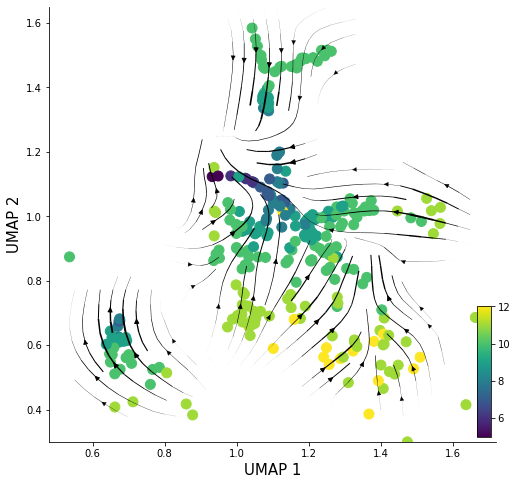

In [18]:
fig, ax = plt.subplots()
scatter = ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=sd.cell_generation, s=100)
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=0.12, lw_coef=10000)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([0.3, 1.65])

In [19]:
sd = pv.pseudo_time.calc_phylo_pseudotime(sd, n_neighbors=280)

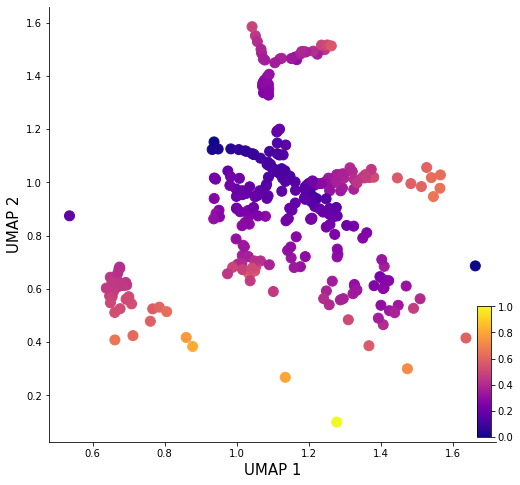

In [20]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(8,8)
scatter = ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=100, c=sd.phylo_pseudotime,cmap='plasma')
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')

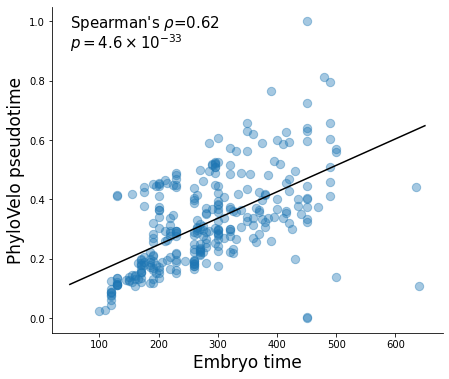

In [26]:
x = cell_annotation.loc[sample]['embryo.time'].to_numpy()
y = sd.phylo_pseudotime

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(50,650,60) + b

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(50,650,60), y_est, '-', c='k')
ax.set_xlabel('Embryo time', fontsize=17)
ax.set_ylabel('PhyloVelo pseudotime', fontsize=17)
# ax.text(50, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(50, 0.98, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(50, 0.91, r'$p={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)